# Import and prepare data

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
import datetime
import time
import os
import seaborn as sns

In [ ]:
def preprocessing(df):
  df1 = pd.DataFrame()
  df1['Date'] = pd.date_range(start = '2000-01-01', end = '2023-06-16' )
  df1['Product_weight'] = df1['Date'].apply(lambda x: df.loc[df['Last_catch_date']==x,'Product_weight'].values[0]
                                            if df.loc[df['Last_catch_date']==x,'Product_weight'].shape[0] == 1 else None)
  # xử lý missing
  df1['Product_weight'] = df1['Product_weight'].interpolate(method='linear').fillna(method='bfill')
  df1['Product_weight'] = df1['Product_weight']/1000
  return df1

In [ ]:
#df1:cod, df2: haddock, df3: halibut
df = pd.read_csv('/content/NortheastArcticCod.csv',parse_dates=['Last_catch_date'])
df1 = preprocessing(df)
df = pd.read_csv('/content/NortheastArcticHaddock.csv',parse_dates=['Last_catch_date'])
df2 = preprocessing(df)
df = pd.read_csv('/content/AtlanticHalibut.csv',parse_dates=['Last_catch_date'])
df3 = preprocessing(df)
del df

<Axes: xlabel='Date'>

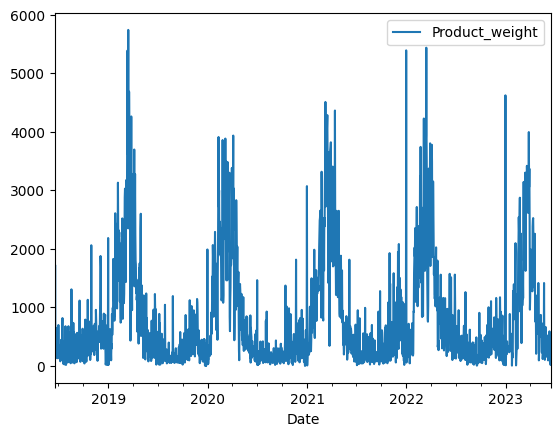

In [ ]:
df1.set_index('Date').iloc[-365*5:,:].plot()

### Dataset Statistic

In [ ]:
import statistics as st

def get_stat(df):
  stat_ = df.describe()
  mode = st.mode(df['Product_weight'])
  cv = df['Product_weight'].std()/df1['Product_weight'].mean()
  kurt = df['Product_weight'].kurtosis()
  skew = df['Product_weight'].skew()
  var = df['Product_weight'].std()**2
  d = {'var':var,'mode':mode,'cv':cv,'kurt':kurt,'skew':skew}
  output = pd.DataFrame()
  tmp = pd.DataFrame([d]).T.rename(columns={0:'Product_weight'})
  stat_ = pd.concat([stat_,tmp])
  stat_ = stat_.rename(index={'50%':'median'})
  li =  ['count','mean','var','std','median','min','max','mode','25%','75%','cv','kurt','skew']
  stat_ = stat_.loc[li]
  return stat_

In [ ]:
get_stat(df1)

,Product_weight
count,8568.000000
mean,668.102098
var,649881.165946
std,806.152074
median,379.378500
min,0.007000
max,5744.075200
mode,71.441000
25%,152.770200
75%,834.418750


In [ ]:
get_stat(df2)

,Product_weight
count,8568.000000
mean,173.369969
var,28576.407676
std,169.045579
median,126.120200
min,0.002000
max,2009.307900
mode,0.012000
25%,61.759633
75%,230.166125


In [ ]:
get_stat(df3)

,Product_weight
count,8568.000000
mean,3.923664
var,20.784164
std,4.558965
median,2.586600
min,0.000000
max,64.504000
mode,0.190000
25%,1.022075
75%,5.117325


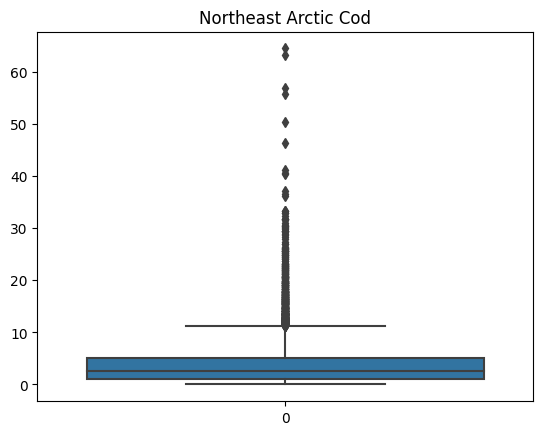

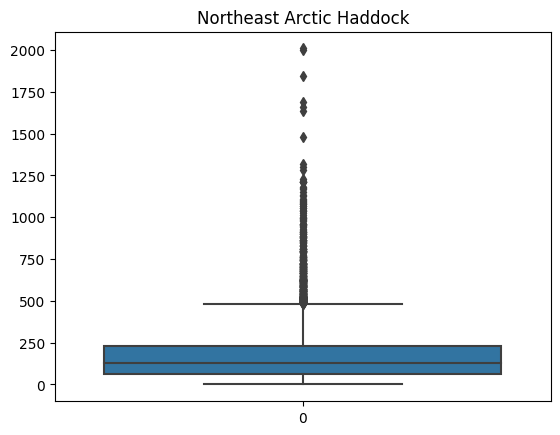

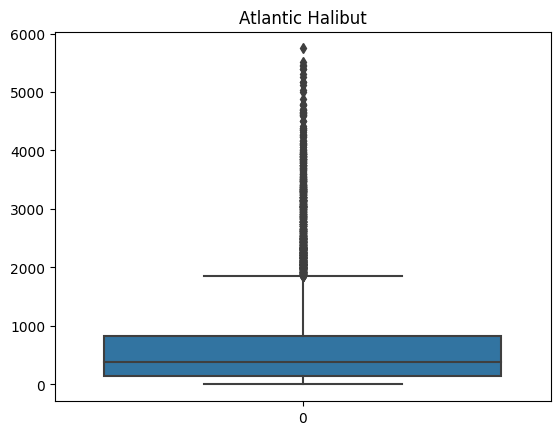

In [ ]:
sns.boxplot(df3['Product_weight'])
plt.title('Northeast Arctic Cod')
plt.show()

sns.boxplot(df2['Product_weight'])
plt.title('Northeast Arctic Haddock')
plt.show()

sns.boxplot(df1['Product_weight'])
plt.title('Atlantic Halibut')
plt.show()

In [ ]:
'Northeast Arctic Cod'
'Northeast Arctic Haddock'
'Atlantic Halibut'

'Atlantic Halibut'

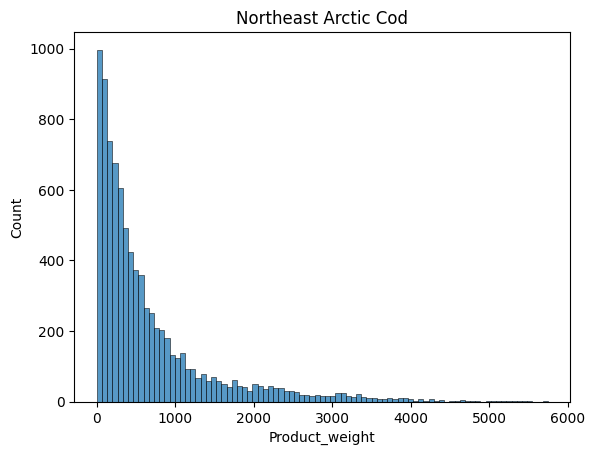

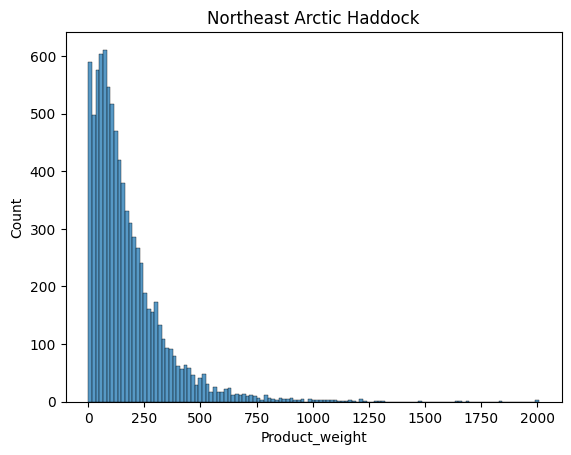

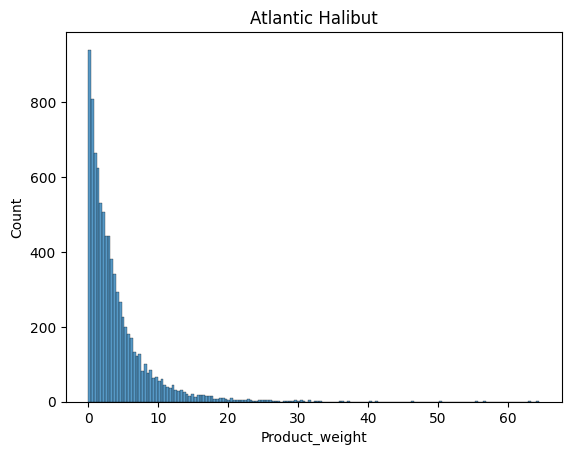

In [ ]:
sns.histplot(df1['Product_weight'])
plt.title('Northeast Arctic Cod')
plt.show()

sns.histplot(df2['Product_weight'])
plt.title('Northeast Arctic Haddock')
plt.show()

sns.histplot(df3['Product_weight'])
plt.title('Atlantic Halibut')
plt.show()

In [ ]:

# from pandas import read_csv
# from matplotlib import pyplot
# from statsmodels.tsa.seasonal import seasonal_decompose
# #series = read_csv('airline-passengers.csv', header=0, index_col=0)
# df2 = df1.copy()
# df2['Month'] = df2['Date'].dt.month
# df2['Year'] = df2['Date'].dt.year

# s = df2[(df2.Year==2020)&(df2.Month.isin([1,2,3,4,5,6]))].set_index('Date')["Product_weight"]
# result = seasonal_decompose(s, model='multiplicative')
# result.plot()
# pyplot.show()

In [ ]:
from sklearn.model_selection import train_test_split

def split_train_val_test(df, train_size = 0.7, val_size = 0.1, test_size = 0.2):
  train,test = train_test_split(df,train_size=train_size,shuffle=False)
  val,test = train_test_split(test,train_size= val_size/(1-train_size),shuffle=False)
  return train,val, test

def roll_back(df, lb = 14, hz = 14):
  X,y = np.empty([0,lb]), np.empty([0,hz])
  aset = df['Product_weight'].values
  for i in range(len(aset)-lb-hz+1):
    a = aset[i:i+lb].reshape(1,-1)
    b = aset[i+lb:i+lb+hz].reshape(1,-1)
    X = np.append(X,a,axis=0)
    y = np.append(y,b,axis=0)
  return X,y

lookback = 90
horizon = 30
train,val,test = split_train_val_test(df3, train_size = 0.7, val_size = 0.1, test_size = 0.2)

scaler = StandardScaler()
train['Product_weight'] = scaler.fit_transform(train['Product_weight'].values.reshape(-1,1))
val['Product_weight'] = scaler.transform(val['Product_weight'].values.reshape(-1,1))
test['Product_weight'] = scaler.transform(test['Product_weight'].values.reshape(-1,1))

X_train,y_train = roll_back(train, lb = lookback, hz = horizon)
X_val,y_val = roll_back(val, lb = lookback, hz = horizon)
X_test,y_test = roll_back(test, lb = lookback, hz = horizon)
X_Ndays = test.iloc[-lookback:,1].values.reshape(1,-1)

X_Ndays_unscale = scaler.inverse_transform(X_Ndays)
X_val_unscale = scaler.inverse_transform(X_val)
X_test_unscale = scaler.inverse_transform(X_test)
X_train_unscale = scaler.inverse_transform(X_train)

y_train_unscale = scaler.inverse_transform(y_train)
y_val_unscale = scaler.inverse_transform(y_val)
y_test_unscale = scaler.inverse_transform(y_test)

In [ ]:
test

,Date,Product_weight
6854,2018-10-07,0.570963
6855,2018-10-08,1.126481
6856,2018-10-09,0.717824
6857,2018-10-10,0.576902
6858,2018-10-11,1.394163
...,...,...
8563,2023-06-12,0.009256
8564,2023-06-13,-0.058671
8565,2023-06-14,0.283691
8566,2023-06-15,0.137959


# Time series models

### Metrics

In [ ]:
from sklearn.metrics import *
def get_metrics(g,p,model_name):
  mse = mean_squared_error(g,p)
  rmse = np.sqrt(mean_squared_error(g,p))
  mae = mean_absolute_error(g,p)
  mape = mean_absolute_percentage_error(g,p)
  r2 = r2_score(g,p)
  print('Kết quả đánh giá:')
  print('MSE:',mse)
  print('RMSE:',rmse)
  print('MAE:',mae)
  print('MAPE:',mape)
  print('R2:',r2)
  return {model_name:[mse,rmse,mae,mape,r2]}

In [ ]:
import torch
import tensorflow as tf


def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)

    tf.random.set_seed(seed)
    tf.experimental.numpy.random.seed(seed)
    tf.keras.utils.set_random_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)

In [ ]:
import matplotlib.pyplot as plt

def visualize(test,X_test_unscale,y_test_unscale, pred_test_unscale,pred_30days_unscale):
    plt.figure(figsize=(16,9))
    tmp0 = pd.DataFrame()
    tmp0['Date'] = test['Date'][-120:-30]
    tmp0['w'] = X_test_unscale[-1]

    tmp1 = pd.DataFrame()
    tmp1['Date'] = test['Date'][-30:]
    tmp1['gt'] = y_test_unscale[-1,:]
    tmp1['pd'] = pred_test_unscale[-1,:]

    tmp2 = pd.DataFrame()
    tmp2['Date'] = pd.date_range(start = test['Date'].iloc[-1] + pd.DateOffset(days=1) , end = test['Date'].iloc[-1] + pd.DateOffset(days=30))
    tmp2['30'] = pred_30days_unscale[-1,:]

    a = tmp0.set_index('Date').copy()
    b = tmp1[['Date','gt']].set_index('Date')
    c = tmp2[['Date','30']].set_index('Date')

    new_cols = {x: y for x, y in zip(b.columns, a.columns)}
    a = a.append(b.rename(columns=new_cols))
    new_cols = {x: y for x, y in zip(c.columns, a.columns)}
    a = a.append(c.rename(columns=new_cols))
    plt.plot(a,'r-', alpha=0.7,label='_nolegend_')
    plt.plot(tmp0.set_index('Date'))
    plt.plot(tmp1.set_index('Date')['gt'])
    plt.plot(tmp1.set_index('Date')['pd'])
    plt.plot(tmp2.set_index('Date')['30'])
    plt.legend(['Last 90 days','30 days groundtruth','30 days predicted','Next 30 days'], prop={'size': 20})
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()

### Linear Regresion

Validation set
Kết quả đánh giá:
MSE: 1153180.1342585196
RMSE: 1073.8622510631983
MAE: 766.8720785438329
MAPE: 4.754178203450635
R2: -0.021527434526836586

Test set
Kết quả đánh giá:
MSE: 921784.005383064
RMSE: 960.0958313538623
MAE: 788.8430442833762
MAPE: 12.584774264674094
R2: -0.04434970472814537


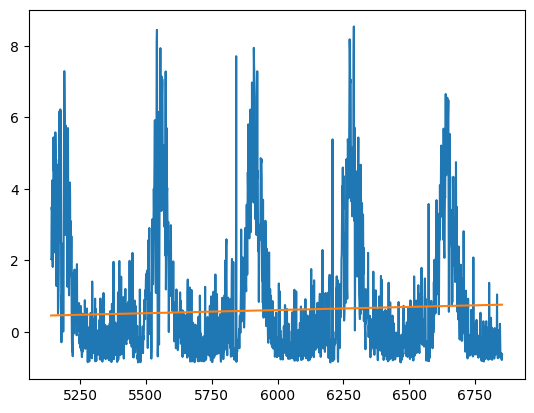

In [ ]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

model_LR = LinearRegression()
model_LR.fit(np.array(train.index).reshape(-1,1),
             train['Product_weight'].values.reshape(-1,1))

pred_val = model_LR.predict(np.array(val.index).reshape(-1,1))
pred_test = model_LR.predict(np.array(test.index).reshape(-1,1))

pred_val_unscale = scaler.inverse_transform(pred_val)
pred_test_unscale = scaler.inverse_transform(pred_test)

print('Validation set')
get_metrics(scaler.inverse_transform(val['Product_weight'].values.reshape(-1,1)),pred_val_unscale,'Linear Regresion')

print('\nTest set')
lr_re = get_metrics(scaler.inverse_transform(test['Product_weight'].values.reshape(-1,1)),pred_test_unscale,'Linear Regresion')

plt.plot(val['Product_weight'])
plt.plot(np.array(val.index).reshape(-1,1),pred_val)

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

# Implement thuật toán KNN
knn_model = KNeighborsRegressor(n_neighbors=100)

# Train mô hình
knn_model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=100)

In [ ]:
# Xem kết quả đánh giá
pred_val = knn_model.predict(X_val)
pred_test = knn_model.predict(X_test)

pred_val_unscale = scaler.inverse_transform(pred_val)
pred_test_unscale = scaler.inverse_transform(pred_test)

print('Validation set')
get_metrics(pred_val_unscale,y_val_unscale,'KNN')

print('\nTest set')
knn_re = get_metrics(pred_test_unscale,y_test_unscale,'KNN')

Validation set
Kết quả đánh giá:
MSE: 679731.5872949068
RMSE: 824.4583599521002
MAE: 500.4694980363353
MAPE: 0.8998230388238417
R2: -2.364129528889461

Test set
Kết quả đánh giá:
MSE: 577951.076077602
RMSE: 760.2309360172092
MAE: 463.88756666050045
MAPE: 0.8203758096066525
R2: -1.7659390293769897


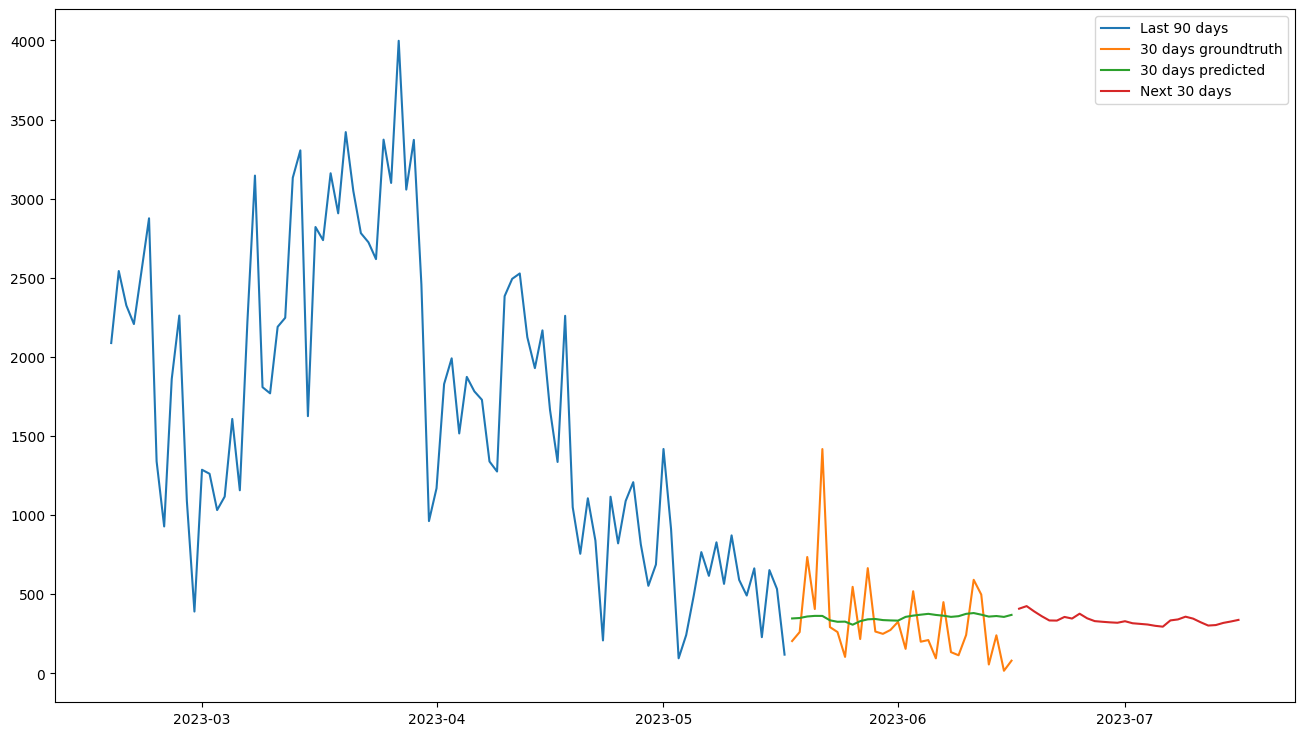

In [ ]:
pred_Ndays = knn_model.predict(X_Ndays)
pred_Ndays_unscale = scaler.inverse_transform(pred_Ndays)
visualize(test,X_test_unscale,y_test_unscale,pred_Ndays_unscale)

### ARIMA

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pmdarima.arima import auto_arima

x_train_arima = np.array(train.index).reshape(-1, 1)
y_train_arima = np.array(train['Product_weight'])

model = auto_arima(y_train_arima, trace=True, error_action='ignore', suppress_warnings=True)

model.fit(y_train_arima)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9535.874, Time=5.76 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11066.781, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10285.465, Time=0.30 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9713.605, Time=0.83 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11064.784, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=9534.088, Time=4.91 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=9579.212, Time=1.40 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9546.557, Time=1.92 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=9535.769, Time=4.75 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=9548.193, Time=3.56 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9534.329, Time=4.09 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=9534.192, Time=10.25 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=9532.235, Time=1.48 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=9577.320, Time=0.43 sec
 ARIMA(1,1,1)(0,0,0)[0]      

ARIMA(order=(1, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
x_val_arima = np.array(val.index).reshape(-1, 1)
y_val_arima = np.array(val['Product_weight'])
y_pred_val_arima =  model.predict(n_periods=len(y_val_arima))

y_val_arima_unscale = scaler.inverse_transform(y_val_arima.reshape(-1,1)).flatten()
y_pred_val_arima_unscale = scaler.inverse_transform(y_pred_val_arima.reshape(-1,1)).flatten()

x_test_arima = np.array(test.index).reshape(-1, 1)
y_test_arima = np.array(test['Product_weight'])
y_pred_test_arima = model.predict(n_periods=len(y_test_arima))

y_test_arima_unscale = scaler.inverse_transform(y_test_arima.reshape(-1,1)).flatten()
y_pred_test_arima_unscale = scaler.inverse_transform(y_pred_test_arima.reshape(-1,1)).flatten()

In [ ]:
print('Validation set')
get_metrics(y_pred_val_arima_unscale,y_val_arima_unscale,"ARIMA")

print('\nTest set')
arima_re = get_metrics(y_pred_test_arima,y_test_arima_unscale,"ARIMA")

Validation set
Kết quả đánh giá:
MSE: 2448764.6754161427
RMSE: 1564.8529245319328
MAE: 1454.086991454208
MAPE: 0.6847304331002736
R2: -159215.70800982582

Test set
Kết quả đánh giá:
MSE: 1594772.2476571254
RMSE: 1262.8429227964677
MAE: 843.8879266029606
MAPE: 306.15449072856984
R2: -35695568540.73596


### ETS

In [ ]:
!pip install statsmodels==0.14.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
trainETS = train.set_index('Date')['Product_weight']
trainETS = pd.Series(trainETS)

valETS = val.set_index('Date')['Product_weight']
valETS = pd.Series(valETS)

testETS = test.set_index('Date')['Product_weight']
testETS = pd.Series(testETS)

In [ ]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
import warnings
warnings.filterwarnings("ignore")

param_grid = {
    'error': ['add'],
    'trend': ['add', None],
    'damped_trend': [False, True],
    'seasonal': ['add', None],
    'seasonal_periods': [3,7,14, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 365, None]
}

best_score = float('inf')
best_params = None
best_model = None

for error in param_grid['error']:
    for trend in param_grid['trend']:
        if trend is None:
            damped_trend_values = [False]  # Chỉ sử dụng False khi trend là None
        else:
            damped_trend_values = param_grid['damped_trend']
        for damped_trend in damped_trend_values:
            for seasonal in param_grid['seasonal']:
                for seasonal_periods in param_grid['seasonal_periods']:
                    model = ETSModel(trainETS,
                                     error=error,
                                     trend=trend,
                                     damped_trend=damped_trend,
                                     seasonal=seasonal,
                                     seasonal_periods=seasonal_periods,
                                     initialization_method='heuristic')
                    model_fit = model.fit()
                    valETS_pred = model_fit.predict(start=valETS.index[0], end=valETS.index[-1])
                    valETS_pred_unscale = scaler.inverse_transform(valETS_pred.values.reshape(-1,1))
                    valETS_unscale = scaler.inverse_transform(valETS.values.reshape(-1,1))
                    score = np.sqrt(mean_squared_error(valETS_pred_unscale, valETS_unscale))

                    if score < best_score:
                        best_score = score
                        best_params = {'error': error, 'trend': trend,
                                       'damped_trend': damped_trend,
                                       'seasonal': seasonal,
                                       'seasonal_periods': seasonal_periods}
                        best_model = model_fit
print('Train set')
get_metrics(best_model.fittedvalues,trainETS,"ETS")

Train set
Kết quả đánh giá:
MSE: 0.7868275169157896
RMSE: 0.8870329852467661
MAE: 0.49496377049012386
MAPE: 6.616787525094033
R2: -1.4361871979779175


{'ETS': [0.7868275169157896,
  0.8870329852467661,
  0.49496377049012386,
  6.616787525094033,
  -1.4361871979779175]}

Validation set
Kết quả đánh giá:
MSE: 19.170306413353913
RMSE: 4.378390847486541
MAE: 3.066914921101063
MAPE: 0.6034275397939814
R2: -7.033850426183031


{'ETS': [19.170306413353913,
  4.378390847486541,
  3.066914921101063,
  0.6034275397939814,
  -7.033850426183031]}

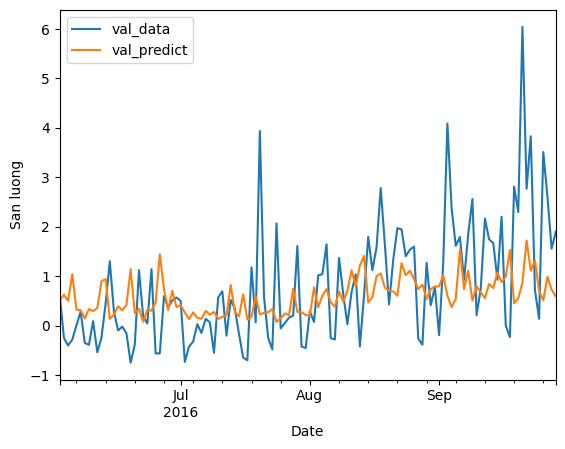

In [ ]:
valETS_pred = best_model.predict(start=valETS.index[0], end=valETS.index[-1])
valETS_pred_unscale = scaler.inverse_transform(valETS_pred.values.reshape(-1,1))
valETS_unscale = scaler.inverse_transform(valETS.values.reshape(-1,1))

valETS.iloc[:120].plot(label='val_data')
valETS_pred.iloc[:120].plot(label='val_predict')
plt.ylabel("San luong")
plt.legend()

print('Validation set')
get_metrics(valETS_pred_unscale,valETS_unscale,'ETS')

Test set
Kết quả đánh giá:
MSE: 27.459552666709286
RMSE: 5.240186319846774
MAE: 3.537890499374698
MAPE: 0.5928447025258538
R2: -9.69682930404529


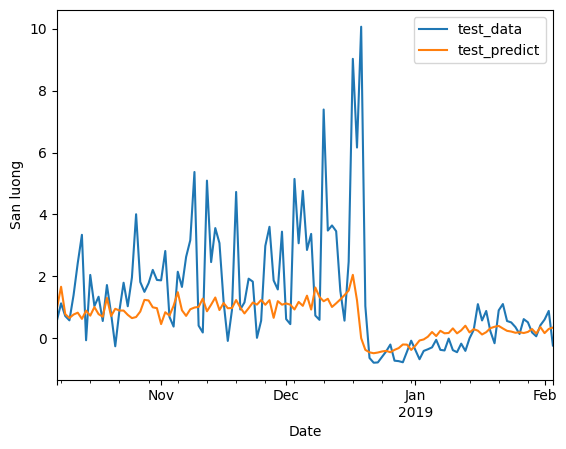

In [ ]:
testETS_pred=best_model.predict(start=testETS.index[0], end=testETS.index[-1])
testETS_pred_unscale = scaler.inverse_transform(testETS_pred.values.reshape(-1,1)).flatten()
testETS_unscale = scaler.inverse_transform(testETS.values.reshape(-1,1)).flatten()

testETS.iloc[:120].plot(label='test_data')
testETS_pred.iloc[:120].plot(label='test_predict')
plt.ylabel("San luong")
plt.legend()

print('Test set')
ets_re = get_metrics(testETS_pred_unscale,testETS_unscale,'ETS')

In [ ]:
future_pred = best_model.predict(start=testETS.index[-1]+pd.DateOffset(days=1), end=testETS.index[-1] + pd.DateOffset(days=30))
future_pred_unscale = scaler.inverse_transform(future_pred.values.reshape(-1,1)).flatten()
future_pred_unscale

array([ 6.58528458,  9.26289043,  5.96656753,  6.29204088,  5.30641278,
        6.21504781,  6.1426893 ,  6.77845718, 10.37848652,  7.75261967,
        6.18370433,  7.6352259 ,  6.41184452,  6.5428189 ,  6.00264876,
        5.50610268,  6.01622046,  5.60880369,  5.53119874,  6.12901825,
        5.84795251,  6.05037512,  5.53500793,  5.67649883,  5.78878568,
        8.07185145,  6.05191976,  5.71379316,  7.37083791,  5.46815793])

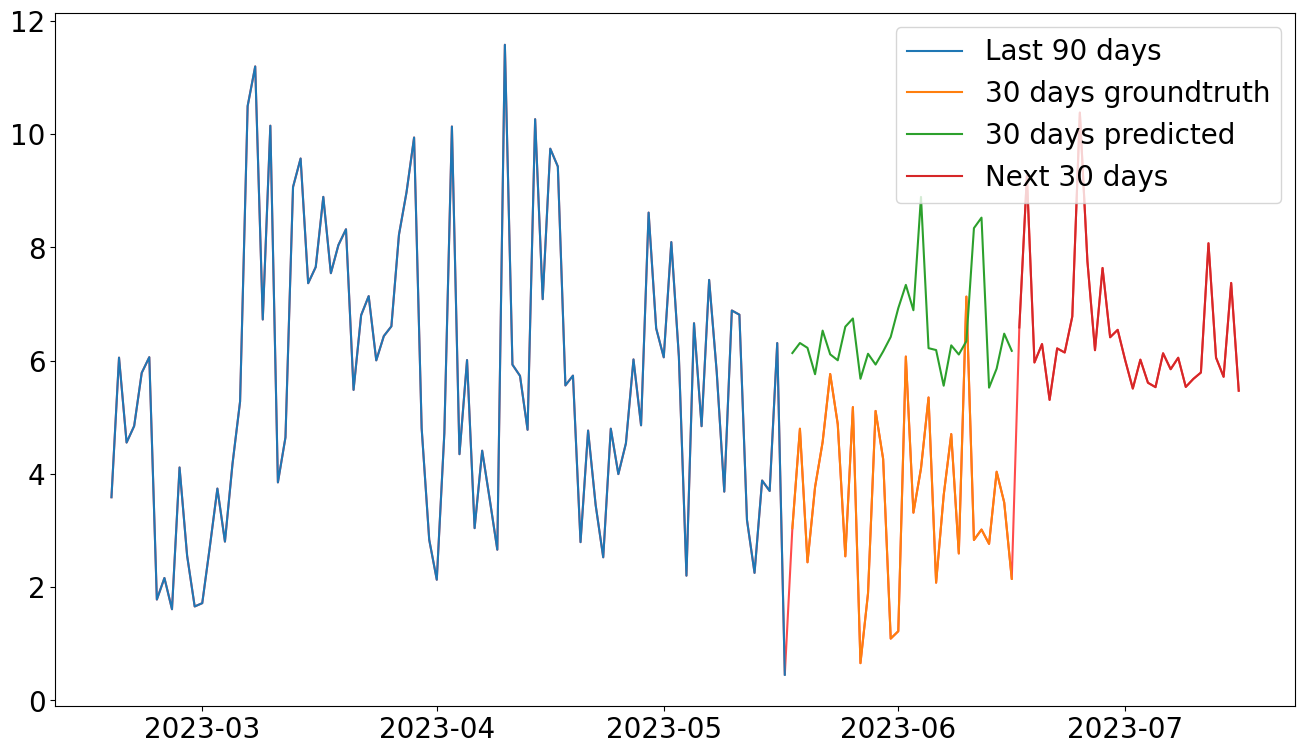

In [ ]:
visualize(test,X_test_unscale,testETS_unscale.reshape(1,-1)[:,-30:],
          testETS_pred_unscale.reshape(1,-1)[:,-30:],future_pred_unscale.reshape(1,-1))

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
model_RF = RandomForestRegressor(n_estimators = 100, random_state=42)
model_RF.fit(X_train,y_train)

RandomForestRegressor(random_state=42)

In [ ]:
pred_val = model_RF.predict(X_val)
pred_test = model_RF.predict(X_test)

pred_val_unscale = scaler.inverse_transform(pred_val)
pred_test_unscale = scaler.inverse_transform(pred_test)

print('\nValidation set')
get_metrics(pred_val_unscale,y_val_unscale,'Random Forest')

print('\nTest set')
rf_re = get_metrics(pred_test_unscale,y_test_unscale,'Random Forest')


Validation set
Kết quả đánh giá:
MSE: 459660.07716456143
RMSE: 677.9823575614349
MAE: 459.15937290758944
MAPE: 0.6373516034528922
R2: -0.0053647705900238185

Test set
Kết quả đánh giá:
MSE: 431051.32852312323
RMSE: 656.5449935252901
MAE: 433.3477249535642
MAPE: 0.633631061876255
R2: 0.000430738776936949


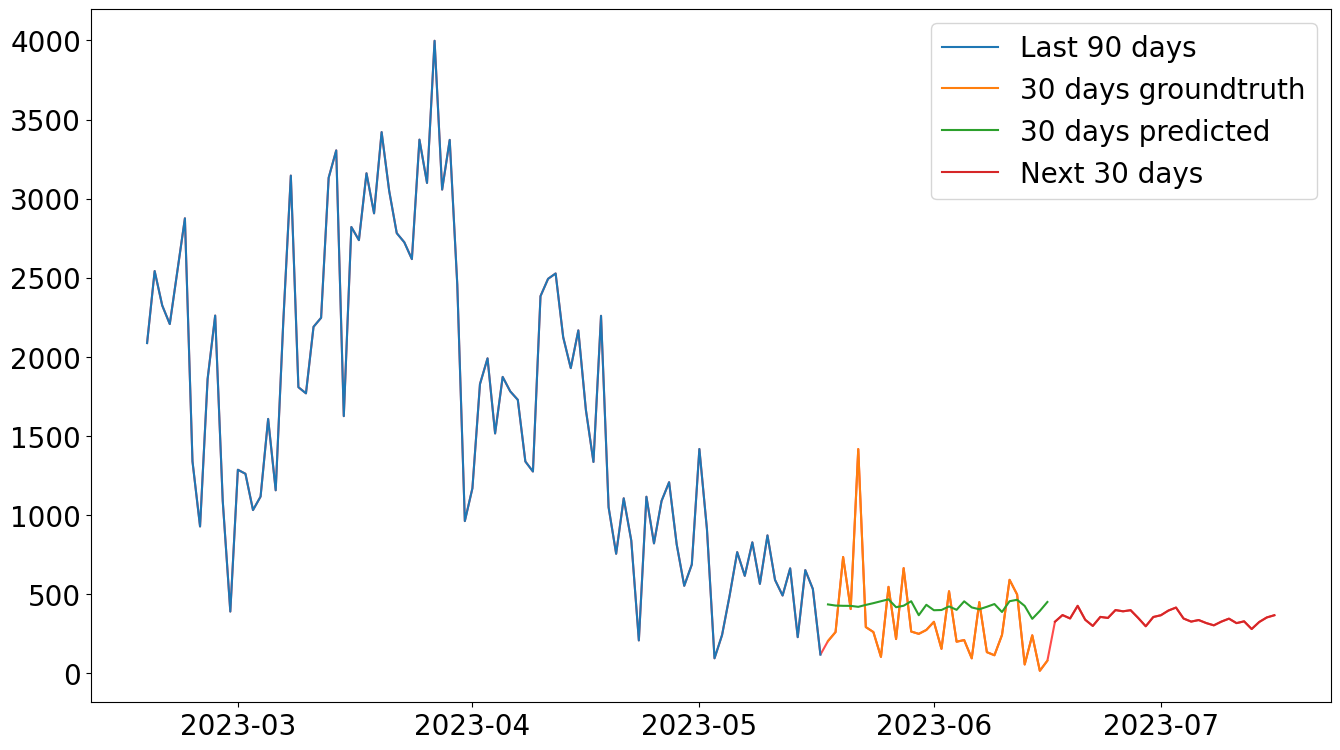

In [ ]:
pred_Ndays = model_RF.predict(X_Ndays)
pred_Ndays_unscale = scaler.inverse_transform(pred_Ndays)
visualize(test,X_test_unscale,y_test_unscale,pred_test_unscale,pred_Ndays_unscale)

### Simple RNN

In [ ]:
from keras.models import Sequential
from keras.layers import Input, Reshape,Dense, SimpleRNN,LSTM,GRU
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.callbacks import ModelCheckpoint
import math

set_seed()
model_RNN = Sequential()
model_RNN.add(Reshape((lookback, 1), input_shape=(lookback,))) # chuyen shape (14,) ve (14,1)
model_RNN.add(SimpleRNN(32, activation='tanh', return_sequences=True))
model_RNN.add(SimpleRNN(32, activation='tanh', return_sequences=False))
model_RNN.add(Dense(horizon))

loss = MeanSquaredError()
optimizer = Adam(learning_rate=0.01)

model_RNN.compile(optimizer=optimizer, loss=loss)
model_RNN.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_3 (Reshape)         (None, 90, 1)             0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 90, 32)            1088      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 30)                990       
                                                                 
Total params: 4,158
Trainable params: 4,158
Non-trainable params: 0
_________________________________________________________________


In [ ]:
save_best = ModelCheckpoint('bestRNN.hdf5', save_best_only=True, monitor='val_loss', mode='min')
model_RNN.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size=64,epochs=5, callbacks=[save_best])

Epoch 1/5
92/92 [==============================] - 17s 168ms/step - loss: 0.8223 - val_loss: 1.3550
Epoch 2/5
92/92 [==============================] - 15s 161ms/step - loss: 0.7954 - val_loss: 1.3648
Epoch 3/5
92/92 [==============================] - 15s 163ms/step - loss: 0.7937 - val_loss: 1.3760
Epoch 4/5
92/92 [==============================] - 15s 159ms/step - loss: 0.7906 - val_loss: 1.3754
Epoch 5/5
92/92 [==============================] - 15s 163ms/step - loss: 0.7825 - val_loss: 1.3724


In [ ]:
# load trang thai mo hinh tot nhat (val loss nho nhat)
model_RNN.load_weights('bestRNN.hdf5')
pred_val = model_RNN.predict(X_val)
pred_test = model_RNN.predict(X_test)

pred_val_unscale = scaler.inverse_transform(pred_val)
pred_test_unscale = scaler.inverse_transform(pred_test)

print('\nValidation set')
get_metrics(pred_val_unscale,y_val_unscale,'RNN')

print('\nTest set')
rnn_re = get_metrics(pred_test_unscale,y_test_unscale,'RNN')

50/50 [==============================] - 1s 19ms/step

Validation set
Kết quả đánh giá:
MSE: 33726.62867200364
RMSE: 183.6481109949232
MAE: 122.12775115476023
MAPE: 0.6406286348686068
R2: -5.707486792771169

Test set
Kết quả đánh giá:
MSE: 33708.79221342724
RMSE: 183.5995430643204
MAE: 115.71585186184943
MAPE: 0.6578968732599954
R2: -4.605529101675787


1/1 [==============================] - 0s 40ms/step


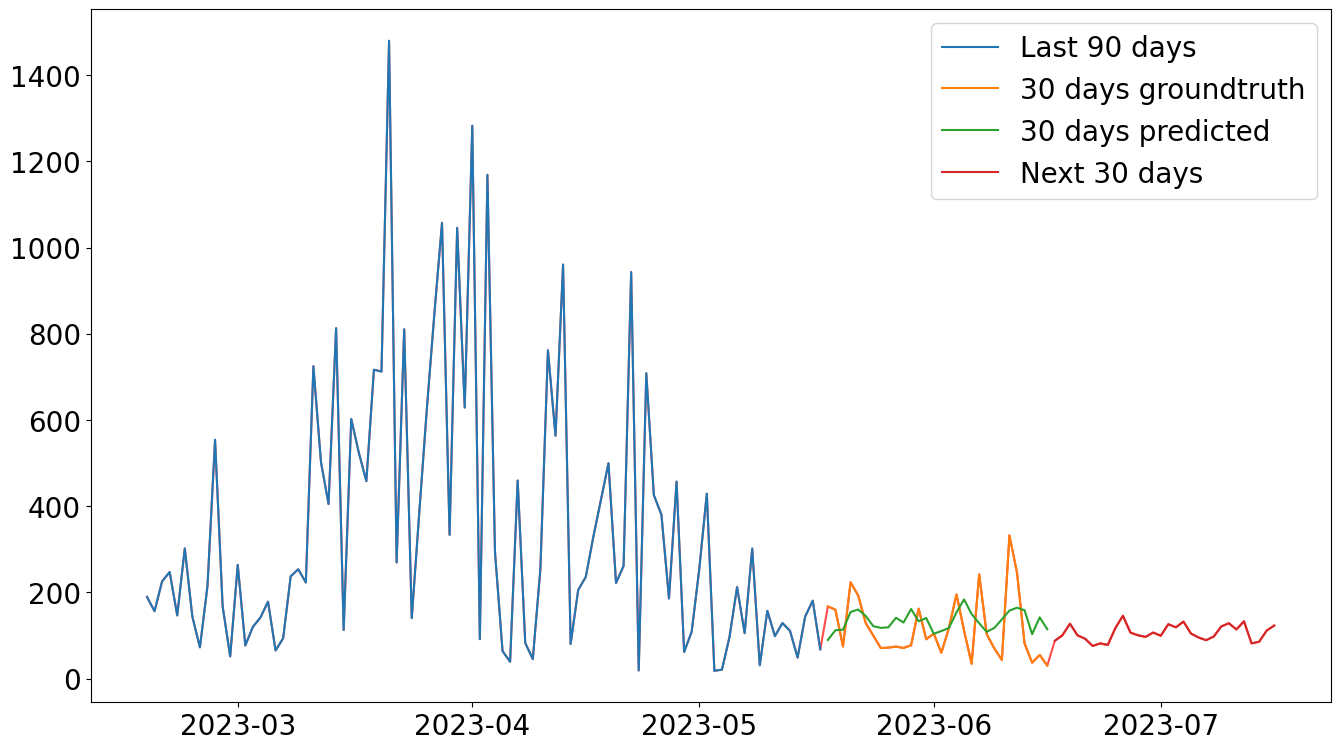

In [ ]:
pred_Ndays = model_RNN.predict(X_Ndays)
pred_Ndays_unscale = scaler.inverse_transform(pred_Ndays)
visualize(test,X_test_unscale,y_test_unscale,pred_test_unscale,pred_Ndays_unscale)

### LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import Input, Reshape,Dense, SimpleRNN,LSTM,GRU
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
import math

set_seed()
model_LSTM = Sequential()
model_LSTM.add(Reshape((lookback, 1), input_shape=(lookback,))) # chuyen shape (30,) ve (30,1)
model_LSTM.add(LSTM(32, activation='tanh', return_sequences=True))
model_LSTM.add(LSTM(32, activation='tanh', return_sequences=False))
model_LSTM.add(Dense(horizon))

optimizer = Adam(learning_rate=0.01)
loss = MeanSquaredError()

model_LSTM.compile(optimizer=optimizer, loss=loss)
model_LSTM.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_4 (Reshape)         (None, 90, 1)             0         
                                                                 
 lstm (LSTM)                 (None, 90, 32)            4352      
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense_4 (Dense)             (None, 30)                990       
                                                                 
Total params: 13,662
Trainable params: 13,662
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.callbacks import ModelCheckpoint

save_best = ModelCheckpoint('bestLSTM.hdf5', save_best_only=True, monitor='val_loss', mode='min')
model_LSTM.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size=64,epochs=5, callbacks=[save_best])

Epoch 1/5
92/92 [==============================] - 4s 21ms/step - loss: 0.7915 - val_loss: 1.3460
Epoch 2/5
92/92 [==============================] - 1s 13ms/step - loss: 0.7714 - val_loss: 1.3412
Epoch 3/5
92/92 [==============================] - 1s 9ms/step - loss: 0.7680 - val_loss: 1.3455
Epoch 4/5
92/92 [==============================] - 1s 9ms/step - loss: 0.7685 - val_loss: 1.3744
Epoch 5/5
92/92 [==============================] - 1s 9ms/step - loss: 0.7610 - val_loss: 1.3526


In [ ]:
# load trang thai mo hinh tot nhat (val loss nho nhat)
model_LSTM.load_weights('bestLSTM.hdf5')
pred_val = model_LSTM.predict(X_val)
pred_test = model_LSTM.predict(X_test)

pred_val_unscale = scaler.inverse_transform(pred_val)
pred_test_unscale = scaler.inverse_transform(pred_test)

print('\nValidation set')
get_metrics(pred_val_unscale,y_val_unscale,'LSTM')

print('\nTest set')
lstm_re = get_metrics(pred_test_unscale,y_test_unscale,'LSTM')

50/50 [==============================] - 0s 5ms/step

Validation set
Kết quả đánh giá:
MSE: 33381.8818250039
RMSE: 182.70709297945686
MAE: 122.13051952892559
MAPE: 0.6246872961674622
R2: -7.859044091850408

Test set
Kết quả đánh giá:
MSE: 33970.68032995216
RMSE: 184.31136788042176
MAE: 115.18799439163814
MAPE: 0.6618468260791265
R2: -5.50710888585827


1/1 [==============================] - 0s 46ms/step


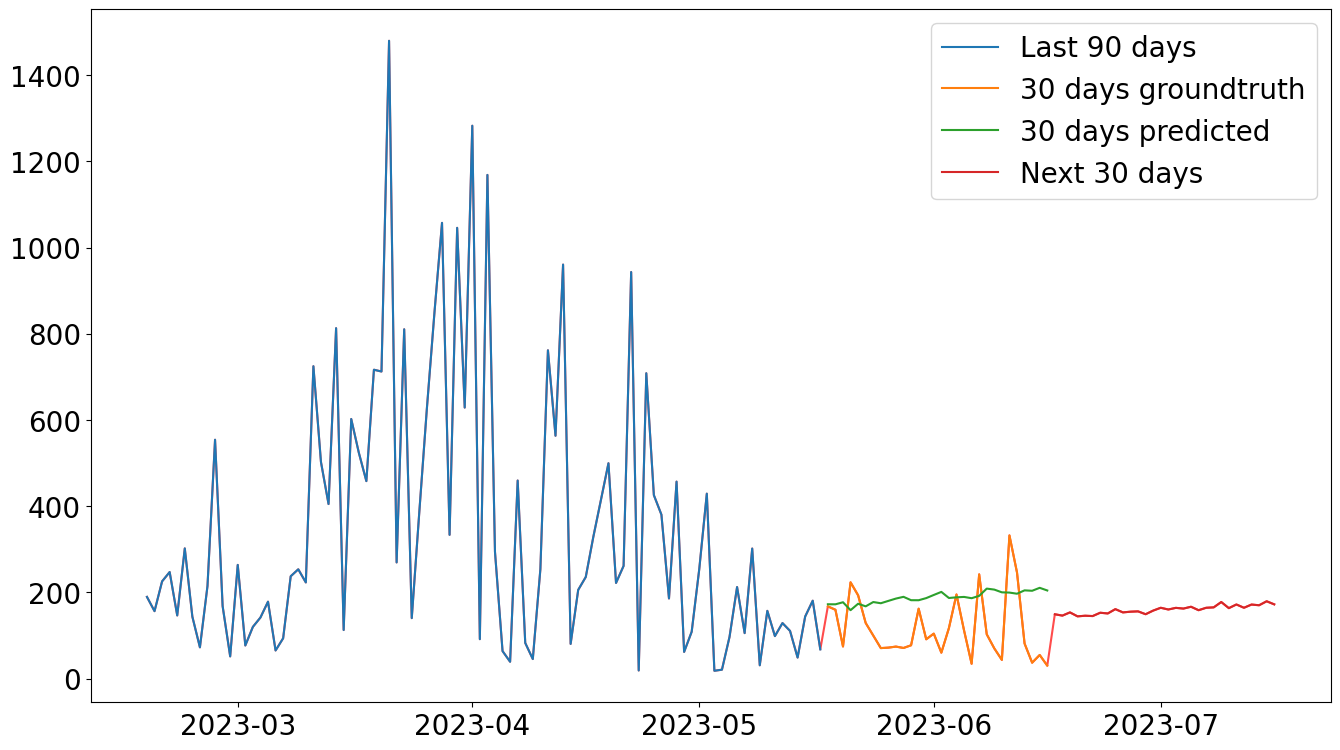

In [ ]:
pred_Ndays = model_LSTM.predict(X_Ndays)
pred_Ndays_unscale = scaler.inverse_transform(pred_Ndays)
visualize(test,X_test_unscale,y_test_unscale,pred_test_unscale,pred_Ndays_unscale)

### GRU

In [ ]:
from keras.models import Sequential
from keras.layers import Input, Reshape,Dense, SimpleRNN,LSTM,GRU
from keras.optimizers import Adam
from keras.losses import MeanSquaredError, MeanAbsoluteError
import math

set_seed()
model_GRU = Sequential()
model_GRU.add(Reshape((lookback, 1), input_shape=(lookback,))) # chuyen shape (14,) ve (14,1)
model_GRU.add(GRU(32, activation='tanh', return_sequences=True))
model_GRU.add(GRU(32, activation='tanh', return_sequences=False))
model_GRU.add(Dense(horizon))

optimizer = Adam(learning_rate=0.01)
loss = MeanSquaredError()

model_GRU.compile(optimizer=optimizer, loss=loss)
model_GRU.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_5 (Reshape)         (None, 90, 1)             0         
                                                                 
 gru_6 (GRU)                 (None, 90, 32)            3360      
                                                                 
 gru_7 (GRU)                 (None, 32)                6336      
                                                                 
 dense_5 (Dense)             (None, 30)                990       
                                                                 
Total params: 10,686
Trainable params: 10,686
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.callbacks import ModelCheckpoint

save_best = ModelCheckpoint('bestGRU.hdf5', save_best_only=True, monitor='val_loss', mode='min')
model_GRU.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size=64,epochs=5, callbacks=[save_best])

Epoch 1/5
92/92 [==============================] - 5s 22ms/step - loss: 0.8510 - val_loss: 1.4099
Epoch 2/5
92/92 [==============================] - 1s 9ms/step - loss: 0.7854 - val_loss: 1.2473
Epoch 3/5
92/92 [==============================] - 1s 8ms/step - loss: 0.7354 - val_loss: 1.1584
Epoch 4/5
92/92 [==============================] - 1s 8ms/step - loss: 0.6958 - val_loss: 1.5699
Epoch 5/5
92/92 [==============================] - 1s 8ms/step - loss: 0.6707 - val_loss: 1.5953


In [ ]:
# load trang thai mo hinh tot nhat (val loss nho nhat)
model_GRU.load_weights('bestGRU.hdf5')
pred_val = model_GRU.predict(X_val)
pred_test = model_GRU.predict(X_test)

pred_val_unscale = scaler.inverse_transform(pred_val)
pred_test_unscale = scaler.inverse_transform(pred_test)

print('\nValidation set')
get_metrics(pred_val_unscale,y_val_unscale,'GRU')

print('\nTest set')
gru_re = get_metrics(pred_test_unscale,y_test_unscale,'GRU')

50/50 [==============================] - 0s 5ms/step

Validation set
Kết quả đánh giá:
MSE: 16.041318831674484
RMSE: 4.005161523793327
MAE: 2.738350953706169
MAPE: 0.8504887104797573
R2: -2.2293933569977993

Test set
Kết quả đánh giá:
MSE: 26.348740535623556
RMSE: 5.133102427930263
MAE: 3.3305183215132836
MAPE: 0.7546822103624328
R2: -4.324335441736213


1/1 [==============================] - 0s 28ms/step


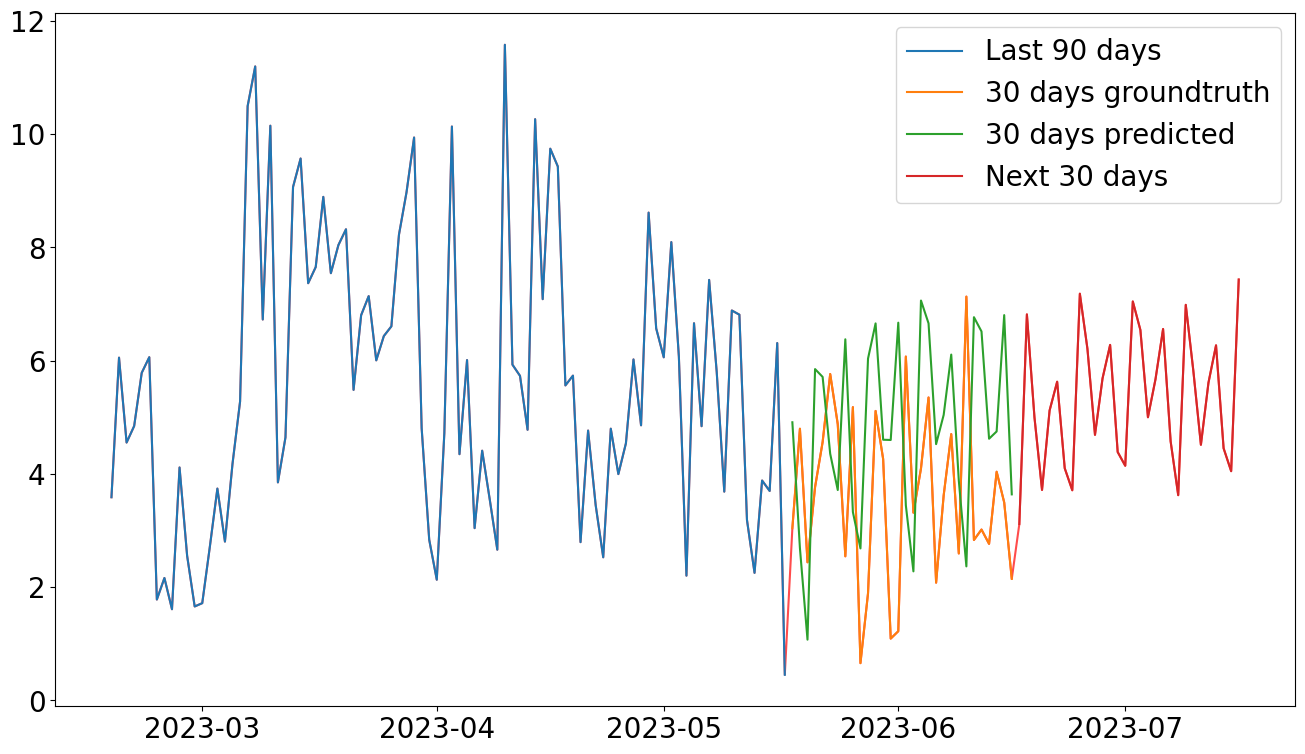

In [ ]:
pred_Ndays = model_GRU.predict(X_Ndays)
pred_Ndays_unscale = scaler.inverse_transform(pred_Ndays)
visualize(test,X_test_unscale,y_test_unscale,pred_test_unscale,pred_Ndays_unscale)

### Summary

In [ ]:
pd.set_option('display.float_format', lambda x: '%.8f' % x)

re_ = [lr_re,arima_re,ets_re,rf_re,knn_re,rnn_re,lstm_re,gru_re]
all_re = {}
for r in re_:
  all_re.update(r)

results = pd.DataFrame(all_re)
results.index = ['MSE','RMSE','MAE','MAPE','R2']
results.T

,MSE,RMSE,MAE,MAPE,R2
Linear Regresion,921784.00538306,960.09583135,788.84304428,12.58477426,-0.04434970
ARIMA,1594772.24765713,1262.84292280,843.88792660,306.15449073,-35695568540.73596191
ETS,2216239.36676389,1488.70392179,1390.54945226,0.68146004,-46.15100374
Random Forest,495427.62837483,703.86620062,450.57396986,0.68574040,-0.79809159
KNN,577951.07607760,760.23093602,463.88756666,0.82037581,-1.76593903
RNN,556621.93373696,746.07099779,484.58927282,0.83582283,-0.96629024
LSTM,508350.58413622,712.98708553,463.61279323,0.68232538,-0.77712057
GRU,468889.09526433,684.75477017,447.90197451,0.66719558,-0.54082660
